# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = False
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

train_data = lgb.Dataset(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_train_lightgbm.bin')
validation_data = lgb.Dataset(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_validation_data_lightgbm.bin')

x_train = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_train.csv')
y_train = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_y_train.csv')

x_val = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_val.csv')
y_val = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_y_val.csv').sale  # -> save as pd.Series

x_pred = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_pred.csv')

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

In [4]:
# downcast numerical values to reduce mem usage
x_train = utils.reduce_mem_usage(x_train)
x_val = utils.reduce_mem_usage(x_val)
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to  4.77 Mb (74.1% reduction)
Mem. usage of decreased to  0.85 Mb (74.1% reduction)
Mem. usage of decreased to 11.07 Mb (64.7% reduction)


# Model Training & Forecasting (LightGBM)

In [5]:

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'max_bin' : 128 ,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round = 1000 ,
                verbose_eval = 25, early_stopping_rounds=20)

y_pred = gbm.predict(x_pred)

Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 1.31808	valid_1's rmse: 1.46571
Early stopping, best iteration is:
[11]	training's rmse: 1.38284	valid_1's rmse: 1.45479


# Training Analysis

Plotting metrics recorded during training...


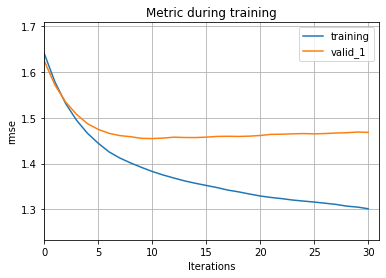

In [6]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


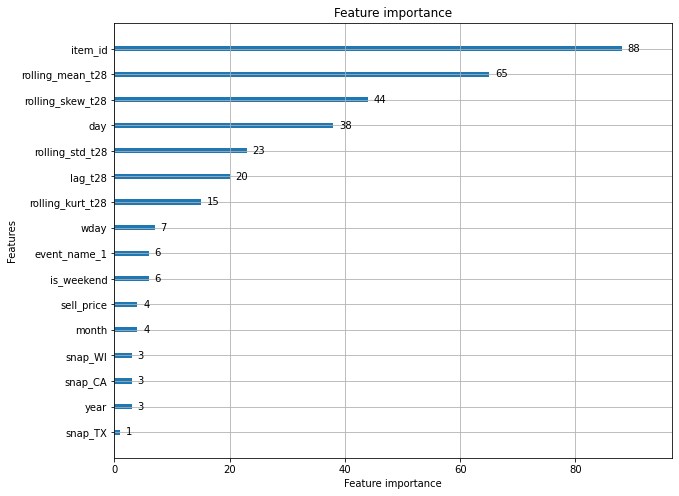

In [7]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Printout Forecasts

In [8]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [9]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [10]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [11]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.301834,0.301834,0.301834,0.328110,0.328110,0.393233,0.393233,0.393233,0.393233,...,0.393233,0.393233,0.393233,0.393233,0.393233,0.436488,0.436488,0.436488,0.328110,0.328110
1,HOBBIES_1_002_TX_2_validation,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,...,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.281083
2,HOBBIES_1_003_TX_2_validation,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,...,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454
3,HOBBIES_1_004_TX_2_validation,1.112133,1.162436,1.162436,1.112133,1.162436,1.162436,1.112133,1.112133,1.112133,...,1.162436,1.112133,1.112133,1.162436,1.162436,1.112133,1.162436,1.162436,1.112133,1.162436
4,HOBBIES_1_005_TX_2_validation,0.768330,0.768330,0.768330,0.768330,0.768330,0.768330,0.768330,0.768330,0.768330,...,0.768330,0.768330,0.768330,0.768330,0.768330,0.768330,0.588720,0.588720,0.671351,0.588720
5,HOBBIES_1_006_TX_2_validation,0.569425,0.569425,0.569425,0.636740,0.719384,0.719384,0.719384,0.636740,0.636740,...,0.569425,0.569425,0.569425,0.569425,0.569425,0.569425,0.569425,0.569425,0.569425,0.569425
6,HOBBIES_1_007_TX_2_validation,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,0.263454,...,0.281083,0.281083,0.301834,0.301834,0.301834,0.301834,0.301834,0.281083,0.281083,0.281083
7,HOBBIES_1_008_TX_2_validation,1.787028,1.746856,2.624653,2.629453,1.882968,2.026904,1.841941,1.595801,2.073409,...,1.758707,2.354573,2.548685,3.872882,1.862998,2.278218,3.065101,2.218862,1.890912,1.806327
8,HOBBIES_1_009_TX_2_validation,0.436488,0.436488,0.357986,0.357986,0.357986,0.357986,0.436488,0.490212,0.490212,...,0.490212,0.490212,0.560555,0.560555,0.560555,0.560555,0.560555,0.560555,0.560555,0.589163
9,HOBBIES_1_010_TX_2_validation,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.685530,...,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.714139,0.685530


# Submit to Kaggle 

In [12]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"
